# Методы семейства «актор-критик»

## Реализация

### Установка библиотек, модулей и зависимостей

In [1]:
!pip install -q gymnasium atari-py gymnasium[atari] gymnasium[accept-rom-license]
!pip install -q stable-baselines3[extra]
!pip install moviepy==1.0.3
!pip install wandb
!pip install imageio_ffmpeg
!pip install gymnasium[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 18.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.1 MB/s eta 0:00:00
     ━━━━━━

In [15]:
import wandb
import time
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

import gymnasium as gym

from stable_baselines3 import SAC

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

%matplotlib inline


In [16]:
import warnings

# Бесят эти предупреждения об устаревании

warnings.filterwarnings('ignore', category=DeprecationWarning)


## Дополнительные полезности

In [4]:
!wandb login
wandb.init(
    project="SAC_Pybullet",
    entity='Senich17')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: senich17. Use `wandb login --relogin` to force relogin


In [5]:
class WandbCustomCallback(BaseCallback):
    def __init__(self, verbose=0, **kwargs):
        super(WandbCustomCallback, self).__init__(verbose, **kwargs)
        self.step = 0
        self.hyperparams = kwargs  # Передача гиперпараметров через **kwargs
        self.rewards= []

    def _on_step(self) -> bool:
        self.step += 1
        infos = self.locals["infos"]

        for info in infos:
            if "episode" in info.keys():
                wandb.log({"reward": info["episode"]["r"], "length": info["episode"]["l"]}, step=self.step)

        return True

    def _on_episode_start(self) -> None:
        # Начало нового эпизода, создаем новый список для хранения вознаграждений
        self.reward.append([])

        return True


## Ну штош, начнем эксперименты

Сначала оставим гиперпараметры по умолчанию, в своем эксперименте я выбрала коэффиициент энтропии, который регулирует степень исследования агента и количество шагов градиентного спуска при обновлении модели. Ну и на всякий случай - скорость обучения, ну потому, что могу, кто ж мне запретит.

Прежде, чем аргументировать, почему были выбраны именно эти гиперпараметры, необходимо понять, на что они вообще влияют, и тогда сразу станет очевидным мой выбор.

- Коэффициент энтропии (ent_coef):

Регулирует степень исследования агента. Чем выше значение этого коэффициента, тем более случайными будут действия агента, что полезно на начальном этапе обучения, чтобы агент исследовал пространство действий более широко. Однако слишком высокое значение коэффициента энтропии может замедлить сходимость модели или даже привести к нестабильному обучению.

Но в тоже время, если среда имеет большое пространство действий или является сложной, более высокий коэффициент энтропии может быть как раз на пользу, что собственно и будем выяснять.


- Количество шагов градиентного спуска (gradient_steps):

Количество шагов градиентного спуска определяет, сколько раз будет обновлена модель на каждой итерации обучения. Более высокое значение этого параметра может улучшить стабильность обучения и помочь модели достичь лучшей производительности, но как всегда это увеличивает вычислительную сложность обучения.

И как в предыдущем показателе, оптимальное количество шагов градиентного спуска зависит от сложности задачи и архитектуры модели. Но это совершенно не мешает ставить эксперименты!

- Скорость обучения (learning_rate):

Это самый очевидный параметр, он определяет размер шага, с которым модель обновляется в направлении градиента. Один из самых важных гиперпараметров, который влияет на скорость сходимости и качество модели (не только в обучении с подкреплением, но и во всем классическом ML).

Собственно, слишком высокая скорость обучения может привести к расхождению модели, а слишком низкая может привести к медленной сходимости или застреванию в локальных минимумах.


Поэтому и выбор этих гиперпараметров для экспериментов имеет смысл, так как они напрямую влияют на процесс обучения и производительность модели. Тестирование различных значений этих параметров поможет нам найти оптимальные настройки для нашей модели и ее обучения.

(СПОЙЛЕР: самые толковые настройки - по умолчанию Т_Т)

In [17]:
env = gym.make("HalfCheetah-v4") # создаем среду


In [18]:
model = SAC("MlpPolicy", env, verbose=1, learning_rate=0.0003, ent_coef=0.01, gradient_steps=1) # собираем модельку, гиперпараметры по умолчанию


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [19]:
# Будем использовать уже знакомый callback
callback = WandbCustomCallback(model)


In [20]:
start_time = time.time() # заодно посчитаем, за какое время агент научится ходить-бежать


In [21]:
model.learn(total_timesteps=100000, log_interval=4, callback=callback) # завариваем чаек и ждем


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 165      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 77       |
|    time_elapsed    | 51       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -1.63    |
|    critic_loss     | 0.558    |
|    ent_coef        | 0.01     |
|    learning_rate   | 0.0003   |
|    n_updates       | 3899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 596      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 75       |
|    time_elapsed    | 105      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -15.9    |
|    critic_loss     | 1.52     |
|    ent_coef        | 0.01     |
|    learning_

In [22]:
end_time = time.time() # останавливаем таймер
execution_time = end_time - start_time

print(f"Время выполнения обучения: {execution_time} секунд")


Время выполнения обучения: 1231.5243501663208 секунд


In [23]:
# Оценка политики, 10 прогонов с логированием метрик
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)


In [24]:
# Вывод доказательств, что агент пытался как паровозик, который смог

print(f"Среднее вознаграждение: {mean_reward}")
print(f"Стандартное отклонение: {std_reward}")
print(f"Время выполнения обучения: {execution_time} секунд")


Среднее вознаграждение: 2152.5014709
Стандартное отклонение: 617.8566141688166
Время выполнения обучения: 1231.5243501663208 секунд


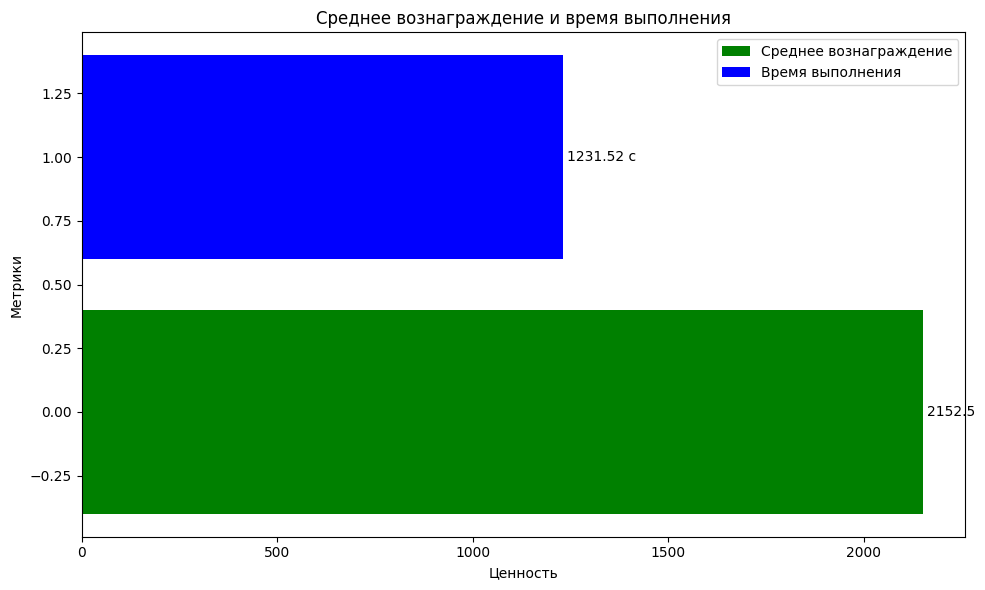

In [32]:
plt.figure(figsize=(10, 6))

bar_reward = plt.barh(0, mean_reward, label='Среднее вознаграждение', color='green')

bar_time = plt.barh(1, execution_time, label='Время выполнения', color='blue')

plt.text(mean_reward + 10, 0, f'{round(mean_reward, 2)}', ha='left', va='center')
plt.text(execution_time + 10, 1, f'{execution_time} с', ha='left', va='center')

plt.title('Среднее вознаграждение и время выполнения')
plt.xlabel('Ценность')
plt.ylabel('Метрики')

plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()


In [33]:
model.save("sac_cheetah")


In [34]:
# Закрытие среды
env.close()


In [35]:
wandb.finish()


length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▂▁▃▄▄▅▅▅▅▅▆▅▆▇▆▆▆▇▇▇▇▇█▇▇██▇▇█▆
length,1000
reward,2378.85784


### Вывод

Запуск 0:

- learning_rate=0.0003: приводит к медленной сходимости модели, но более стабильному обучению.
- ent_coef=0.01: Низкий коэффициент энтропии означает, что модель будет меньше исследовать пространство действий и скорее всего сфокусируется на эксплуатации изученных стратегий.
- gradient_steps=1: Один шаг градиентного спуска после каждого батча наблюдений может снизить вычислительную нагрузку, но может потребовать большего количества итераций для сходимости модели.

На самом деле, как показывает практика, не спроста значения некоторых параметров существуют "по умолчанию". Это те значения, которые чаще всего подходят для большинства задач и уже показали свою эффективность. Но в исследовательских целях мы можем поменять параметры на свой "вкус" и посмотреть, как они повлияют на модель и ее награды.

Отчет: https://wandb.ai/senich17/SAC_Pybullet/reports/SAC-Pybullet-HalfCheetah--Vmlldzo3OTczNjA3?accessToken=g0lr5sqp2acpa5krhcqdhgs7gr4yx42qpx8z8r6r3fzr84zpw80827dnxwgtdaul

## Эксперимент номер раз

Далее код остается неизменным, только поменяем выбранные гиперпараметры и посмотрим на графики и показатели.
Например скорость обучения поставим повыше, увеличим количество шагов градиента и коэффициент энтропии.

In [37]:
wandb.init(
    project="SAC_Pybullet",
    entity='Senich17')

In [38]:
env = gym.make("HalfCheetah-v4")


In [39]:
model = SAC("MlpPolicy", env, verbose=1, learning_rate=0.001, ent_coef=0.1, gradient_steps=2)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [40]:
callback = WandbCustomCallback(model)


In [41]:
start_time = time.time()


In [42]:
model.learn(total_timesteps=100000, log_interval=4, callback=callback)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -171     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 41       |
|    time_elapsed    | 95       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -4.19    |
|    critic_loss     | 0.312    |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.001    |
|    n_updates       | 7798     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -27.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 40       |
|    time_elapsed    | 198      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -7.55    |
|    critic_loss     | 0.4      |
|    ent_coef        | 0.1      |
|    learning_

In [43]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Время выполнения обучения: {execution_time} секунд")


Время выполнения обучения: 2162.2134959697723 секунд


In [44]:
# Оценка модели за 10 прогонов
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)


In [45]:
print(f"Среднее вознаграждение: {mean_reward}")
print(f"Стандартное отклонение: {std_reward}")
print(f"Время выполнения обучения: {execution_time} секунд")


Среднее вознаграждение: 4234.710018400001
Стандартное отклонение: 106.95286426766287
Время выполнения обучения: 2162.2134959697723 секунд


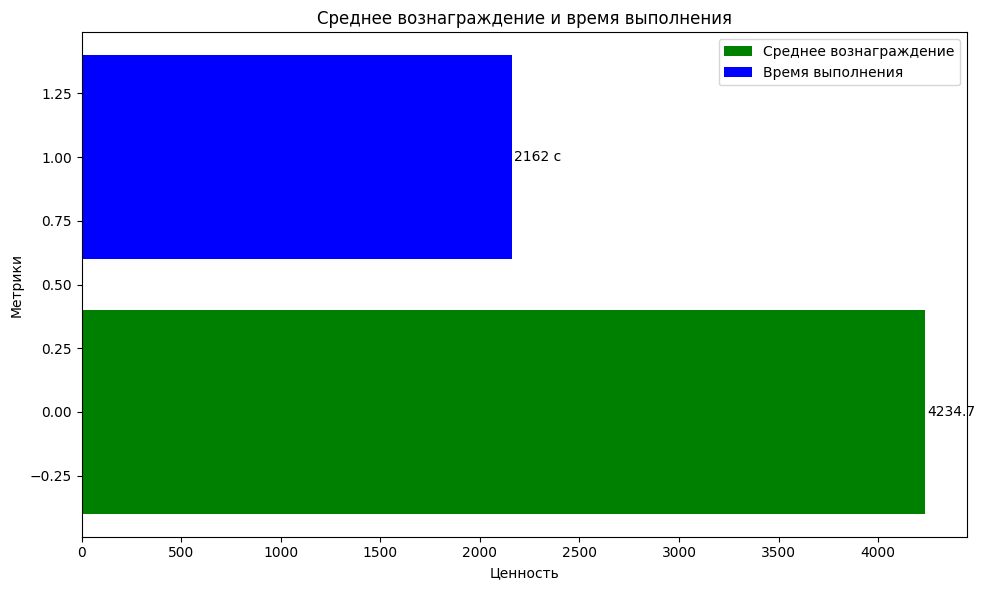

In [46]:
plt.figure(figsize=(10, 6))

bar_reward = plt.barh(0, mean_reward, label='Среднее вознаграждение', color='green')

bar_time = plt.barh(1, execution_time, label='Время выполнения', color='blue')

plt.text(mean_reward + 10, 0, f'{round(mean_reward, 2)}', ha='left', va='center')
plt.text(execution_time + 10, 1, f'{execution_time} с', ha='left', va='center')

plt.title('Среднее вознаграждение и время выполнения')
plt.xlabel('Ценность')
plt.ylabel('Метрики')

plt.legend()

# Честно, я знаю, что эти графики уродливы по своей природе, в конце будут покрасивее
plt.tight_layout()
plt.show()


In [47]:
model.save('sac_cheetah1')


In [48]:
# Закрытие среды
env.close()


In [49]:
wandb.finish()


length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▂▂▁▂▂▁▃▃▂▃▄▄▄▄▄▅▄▅▅▅▅▆▆▆▆▆▇▄▇▇▇▃█▇████
length,1000
reward,3974.68102


### Вывод

Запуск 1:

- learning_rate=0.001: Увеличение learning rate ускоряет сходимость модели, но при этом существует риск нестабильности обучения (наподобие студента: всю неделю бил те самые баклуши, но к экзамену готовился за ночь).
- ent_coef=0.1: Увеличение коэффициента энтропии приводит к исследовательскому поведению модели и ускоряет обучение.
- gradient_steps=2: Увеличение числа шагов градиентного спуска может улучшить сходимость модели, но также увеличит вычислительную нагрузку.

Общий вывод: Второй эксперимент показывает лучшие результаты по среднему вознаграждению, что может указывать на более эффективное обучение модели, но при этом обучение идет значительно медленнее. Интересно, что в процессе обучения заметны скачки на графике вознаграждения, при том, довольно сильные, вполне вероятно, что там можно наблюдать ту самую нестабильность. Агент волотилен Т_Т

Отчет https://wandb.ai/senich17/SAC_Pybullet/reports/SAC-Pybullet-HalfCheetah--Vmlldzo3OTczNTEz

А так же сравнение с предыдущим запуском https://wandb.ai/senich17/SAC_Pybullet/reports/SAC-Pybullet-HalfCheetah--Vmlldzo3OTczNTMz?accessToken=o474p8ewm2yna2eta982lj7cnd20ykaqzsk0em4wy2mc8bg2cq5vmi50orbu5nbe



## Эксперимент номер два

Теперь скорость обучения поставим ниже, количество шагов градиента на 3, коэффициент энтропии оставим как и в предыдущем запуске.

In [50]:
wandb.init(
    project="SAC_Pybullet",
    entity='Senich17')


In [51]:
env = gym.make("HalfCheetah-v4")


In [52]:
model = SAC("MlpPolicy", env, verbose=1, learning_rate=0.0001, ent_coef=0.1, gradient_steps=3)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [53]:
callback = WandbCustomCallback(model)


In [54]:
start_time = time.time()


In [55]:
model.learn(total_timesteps=100000, log_interval=4, callback=callback)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -169     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 33       |
|    time_elapsed    | 120      |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 2.37     |
|    critic_loss     | 1.4      |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.0001   |
|    n_updates       | 11697    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -129     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 32       |
|    time_elapsed    | 245      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | 3.97     |
|    critic_loss     | 0.631    |
|    ent_coef        | 0.1      |
|    learning_

In [56]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Время выполнения обучения: {execution_time} секунд")


Время выполнения обучения: 3163.4966304302216 секунд


In [57]:
# Оценка политики за 10 прогонов
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)


In [58]:
print(f"Среднее вознаграждение: {mean_reward}")
print(f"Стандартное отклонение: {std_reward}")
print(f"Время выполнения обучения: {execution_time} секунд")


Среднее вознаграждение: 4394.6941951
Стандартное отклонение: 71.1067554168165
Время выполнения обучения: 3163.4966304302216 секунд


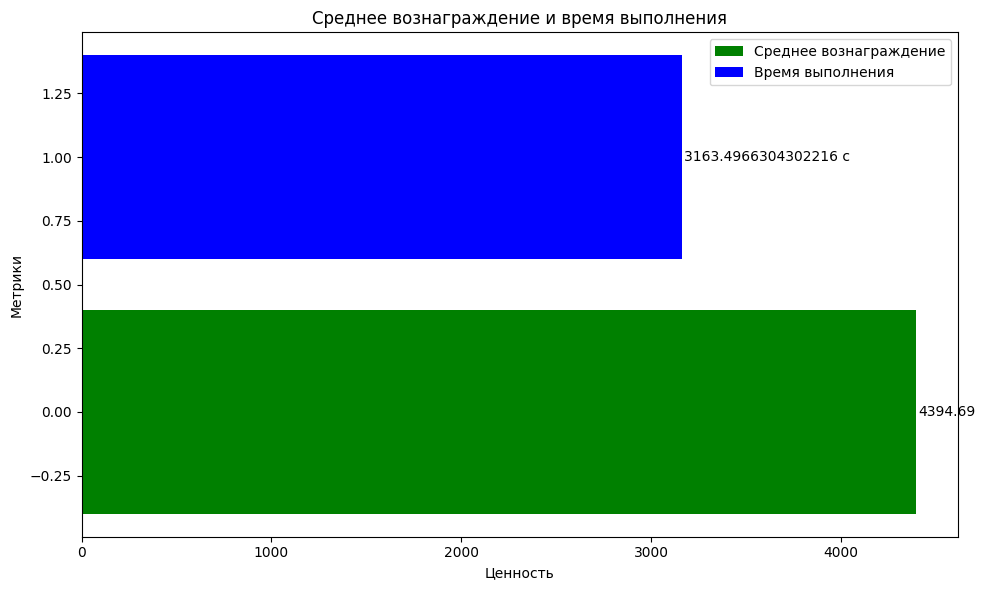

In [60]:
plt.figure(figsize=(10, 6))

bar_reward = plt.barh(0, mean_reward, label='Среднее вознаграждение', color='green')

bar_time = plt.barh(1, execution_time, label='Время выполнения', color='blue')

plt.text(mean_reward + 10, 0, f'{round(mean_reward, 2)}', ha='left', va='center')
plt.text(execution_time + 10, 1, f'{execution_time} с', ha='left', va='center')

plt.title('Среднее вознаграждение и время выполнения')
plt.xlabel('Ценность')
plt.ylabel('Метрики')

plt.legend()

# Честно, я знаю, что эти графики уродливы по своей природе, в конце будут покрасивее
plt.tight_layout()
plt.show()


In [61]:
model.save('sac_cheetah2')


In [62]:
env.close()


In [63]:
wandb.finish()


length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▂▂▂▂▃▃▃▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇██▇▇██████
length,1000
reward,4082.53756


### Вывод

Сравнивая новый запуск с предыдущими двумя экспериментами, мы можем заметить следующие изменения:

Запуск 2:

- learning_rate=0.0001: Дальнейшее уменьшение learning rate снижает скорость сходимости, особенно если он становится слишком маленьким.
- gradient_steps=3: Увеличение числа шагов градиентного спуска дополнительно улучшает сходимость модели, но, ессессно, с увеличением вычислительной нагрузки.

Общий вывод: Новый запуск показывает улучшение производительности по среднему вознаграждению за эпизод, однако увеличение времени обучения может оказать влияние на общую эффективность модели. При этом модель остается довольно стабильной, что радует!

Отчет: https://wandb.ai/senich17/SAC_Pybullet/reports/SAC-Pybullet-HalfCheetah--Vmlldzo3OTc0MzMw?accessToken=wvtcwda8xb1aa1rbzodnf2x2i74jop6d9z4ue7naf1qwbb1ehghyuqpj38bkzqg7

Сравнение с предыдущими запусками: https://api.wandb.ai/links/senich17/98l2k15u

## Эксперимент номер три

Теперь оставим скорость обучения такой же, как в предыдущем
эксперементе, а шаги градиента - по умолчанию, но поменяем коэффициент энтропии на 0.5.

In [64]:
wandb.init(
    project="SAC_Pybullet",
    entity='Senich17')


In [65]:
env = gym.make("HalfCheetah-v4")


In [66]:
model = SAC("MlpPolicy", env, verbose=1, learning_rate=0.0001, ent_coef=0.5, gradient_steps=1)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [67]:
callback = WandbCustomCallback(model)


In [68]:
start_time = time.time()


In [69]:
model.learn(total_timesteps=100000, log_interval=4, callback=callback)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -270     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 77       |
|    time_elapsed    | 51       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -26.4    |
|    critic_loss     | 0.901    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0001   |
|    n_updates       | 3899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -265     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 82       |
|    time_elapsed    | 97       |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -45.2    |
|    critic_loss     | 1.66     |
|    ent_coef        | 0.5      |
|    learning_

In [70]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Время выполнения обучения: {execution_time} секунд")


Время выполнения обучения: 1150.4772300720215 секунд


In [71]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)


In [72]:
print(f"Среднее вознаграждение: {mean_reward}")
print(f"Стандартное отклонение: {std_reward}")
print(f"Время выполнения обучения: {execution_time} секунд")


Среднее вознаграждение: -11.8454462
Стандартное отклонение: 0.7329808270454011
Время выполнения обучения: 1150.4772300720215 секунд


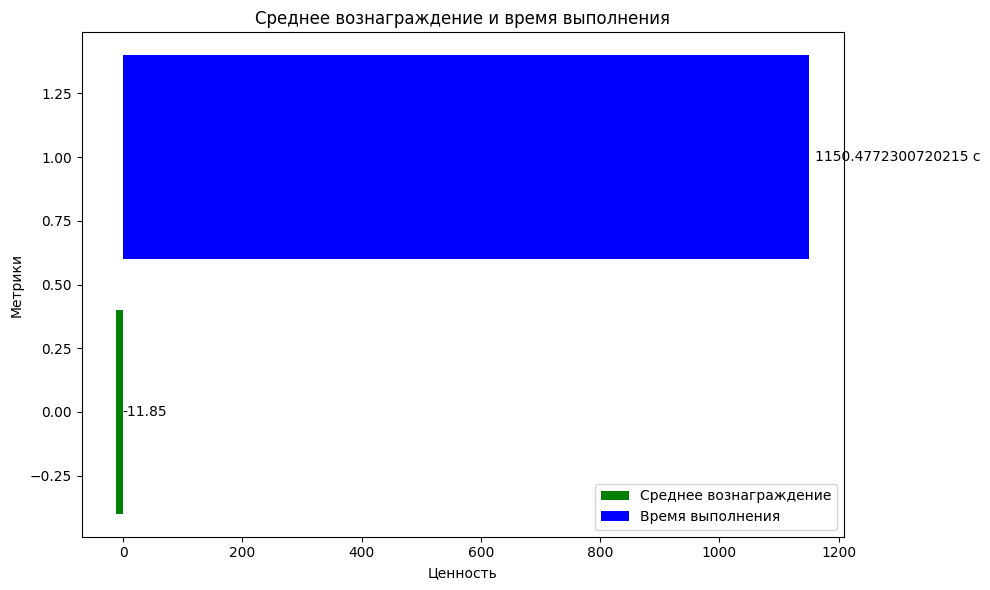

In [73]:
plt.figure(figsize=(10, 6))

bar_reward = plt.barh(0, mean_reward, label='Среднее вознаграждение', color='green')

bar_time = plt.barh(1, execution_time, label='Время выполнения', color='blue')

plt.text(mean_reward + 10, 0, f'{round(mean_reward, 2)}', ha='left', va='center')
plt.text(execution_time + 10, 1, f'{execution_time} с', ha='left', va='center')

plt.title('Среднее вознаграждение и время выполнения')
plt.xlabel('Ценность')
plt.ylabel('Метрики')

plt.legend()

# Честно, я знаю, что эти графики уродливы по своей природе, в конце будут покрасивее
plt.tight_layout()
plt.show()


In [74]:
model.save('sac_cheetah3')


In [75]:
env.close()


In [76]:
wandb.finish()


length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▂▂▄▂▆▃▁▄▁▆▅▅▂▃▂▃▃▄▅▃▅▃▄▅▂▄▃▅▄▄▅▄▄▆▅▅▄▆█▆
length,1000
reward,-153.65195


### Вывод (я не плачу, это дощщ)

Запуск 3:

- ent_coef=0.5: Значительное увеличение коэффициента энтропии приводит к исследовательскому поведению модели, но также вызывает нестабильность обучения, особенно при недостаточном количестве обновлений.

В целом, последний запуск отличается от предыдущих очень сильно, модель как будто перестает получать вознаграждения и пускается в приключения по неизведанной среде, как бы забывая об основной своей цели - обучении.

Важно отметить, что при использовании высокого значения коэффициента энтропии необходимо обеспечить достаточное количество обновлений модели, чтобы стабилизировать обучение и предотвратить возможное разрушение стратегии, что доказывают показатели этого запуска.

Отчет: https://wandb.ai/senich17/SAC_Pybullet/reports/SAC-Pybullet-HalfCheetah--Vmlldzo3OTc0ODMw?accessToken=zhadr9q3yu9h3ne1ai1yugr9335pn4afjtb0cxqab71qm2ucgcwkv3t4hiegipm9

Сравнение с предыдущими запусками: https://api.wandb.ai/links/senich17/po8a2dh1

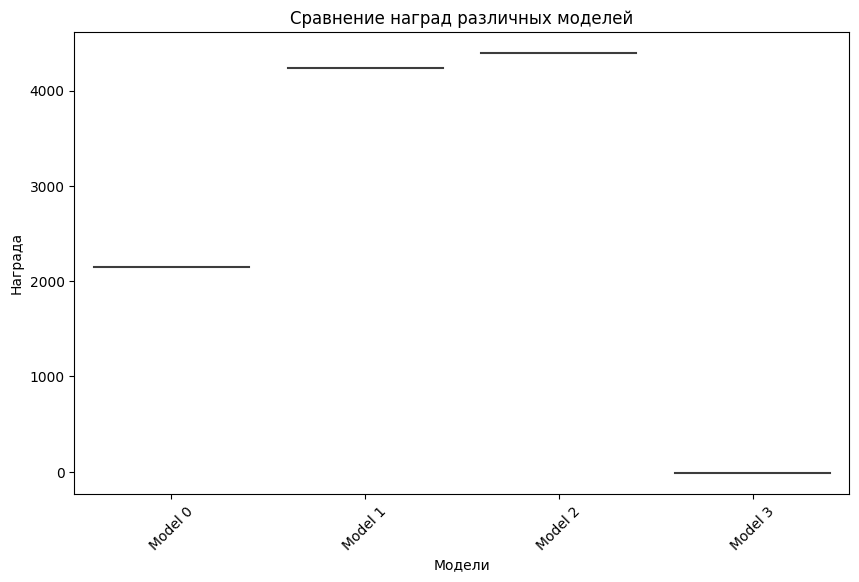

In [77]:
data = {
    "Model 0": [2152.5],
    "Model 1": [4234.7],
    "Model 2": [4394.7],
    "Model 3": [-11.8]
}

df = pd.DataFrame(data)

# Построение Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, inner="point", linewidth=1.5)
plt.title('Сравнение наград различных моделей')
plt.xlabel('Модели')
plt.ylabel('Награда')
plt.xticks(rotation=45)
plt.show()


<ipython-input-86-f52c8a672868>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.columns, y=df.values.flatten(), palette='Set1')


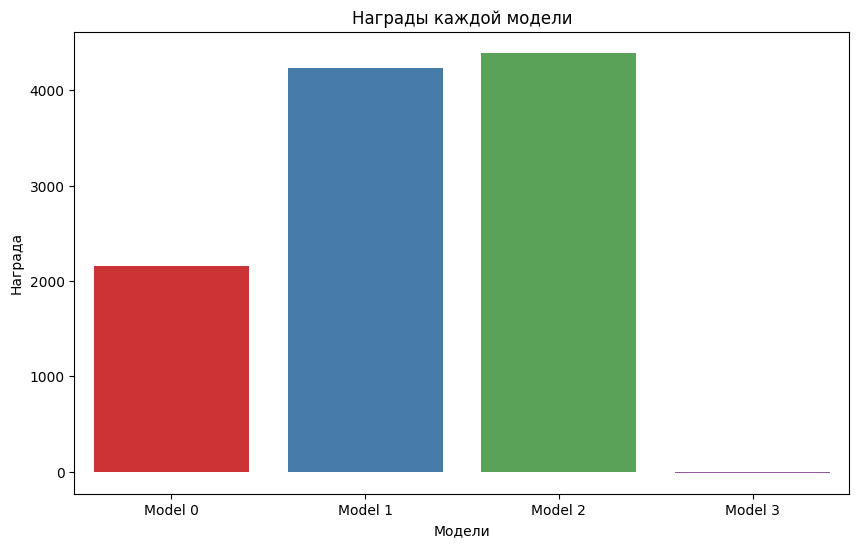

In [86]:
# Создание DataFrame с данными о наградах каждой модели
data = {
    "Model 0": [2152.5],
    "Model 1": [4234.7],
    "Model 2": [4394.7],
    "Model 3": [-11.8]
}

df = pd.DataFrame(data)

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
sns.barplot(x=df.columns, y=df.values.flatten(), palette='Set1')
plt.title('Награды каждой модели')
plt.xlabel('Модели')
plt.ylabel('Награда')
plt.show()


На диаграмме выше можно наглядно увидеть разницу в наградах моделей, но разумеется не одной наградой едины. Еще важно учитывать стабильность обучения в целом, все таки агент должен быть надежен. Помимо этого - внимательно следить за тем, насколько ресурсоемкой становится модель и сколько времени занимает ее обучение. Разумеется, что все зависит от контекста задачи.